## Load Packages

In [2]:
#processing data/dataframes
import pandas as pd
import numpy as np
from scipy import stats

#file structures
from pathlib import Path

#Preprocessing
from scipy.stats import pearsonr, mode 

#plots
import seaborn as sns
from matplotlib import pyplot as plt

#custom functions
from functions import getResponses, chooseData, chooseEmb, getEmbeddings, getData, predModel, corrUserBased #general auxiliary function
from functions import modelPerformance #model training and comparison

#random state
randState = 0

#warning messages
import warnings
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")

## Calculate model performances (only run once/if not already saved)

IPIP

In [ ]:
#fit a single model with specified parameter, report performance
# main model
modelPerformance(m=4, par=5, d="IPIP", e="sentencebert", verbose=1) 

#baseline: Word2Vec
modelPerformance(m=3, par=10, d="IPIP", e="word2vec", verbose=1) #fit a single model with specified parameter, report performance

#baseline: LIWC
modelPerformance(m=0, par=10, d="IPIP", e="liwc", verbose=1) #fit a single model with specified parameter, report performance

#m -> #0: Ridge regression, #1: RidgeClass, #2:KNN, #3: Kernel SVC (RBF), #4: KNN Regression

## Load model performances (run instead of section above -- much faster)

In [9]:
datasets = ["IPIP"]

for d in datasets:
    #best Model (KnnRegression k=5, no reverse-coding):
    m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
    par = 5
    e = 'sentencebert'
    model, modelName = predModel(m,par)

    #load path and necessary variables:
    folder, data = chooseData(d)        
    embeddings, save = chooseEmb(e)     #LIWC, WORD2VEC, SENTENCEBERT
    responses, savePath, items, _ = getResponses(folder, data, 2) #1: Reversed, #2: nonReversed
    responses = responses.astype(float) #get observed responses as floats
    X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings, responses)

    #get embeddings name:
    embName = embeddings.split("_")[2].split(".")[0]

    # import required data and labels
    data_q, constructs_list, list_par, constrAssigned = getData(m, responses, X_pca_stand, folder, data)

    # get predicted responses of chosen model:
    total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
    total_preds.index = total_preds.index.map(str)
    total_preds = total_preds.astype(float)

    #get model performance:
    results, resultsMean = corrUserBased(total_preds, responses)
    corr, pval, ci_lower, ci_upper, t, dof = means
    print("Dataset: " + d.upper())
    print("Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF")
    print([round(corr,3), round(ci_lower,3), round(ci_upper,3), round(pval,3), round(t,3), round(dof,3)])
    print("\n")
    print("Percentage of significant positive correlations: ")
    print(round(np.mean((results.Correlation>0) & (results["p-value"]<0.05)), 3))

Dataset: IPIP
Correlation, lower-CI, upper-CI, p-value, t-statistic, DOF
[0.367, 0.35, 0.383, 0.0, 44.241, 159]


Percentage of significant positive correlations: 
0.994


## Performance Plots (Model & Baselines)

### Calculate and save performance (only run once)

In [3]:
# best performing model:
m   = 4               #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF)
par = 5
e   = 'sentencebert'

model, modelName = predModel(m,par) 

datasets = ['IPIP']
performance = pd.DataFrame(columns=["Dataset", "Model", "Correlation", "p-value", "L1 Loss"])
sig_data = []

#iterate through datasets
for i,nr in zip(datasets, range(len(datasets))):
  #add LIWC - Baseline
      #load prediction and baseline data
  folder, data = chooseData(i)
  responses, savePath, items, _ = getResponses(folder, data, 2)
  total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + e.upper() + "_responses.csv", index_col=0)
  total_dumb = pd.read_csv(savePath + 'baseline_responses.csv', index_col=0) #naive baseline
  responses.index = total_preds.index
      #get performances
  results, resultsMean = corrUserBased(total_preds, responses)
  results_dumb, resultsMean_dumb = corrUserBased(total_dumb, responses)
  results.insert(0,'Model',['Best Model']*results.shape[0])
  results.insert(0,'Dataset',[i]*results.shape[0])
  results_dumb.insert(0,'Model',['Average Response']*results_dumb.shape[0])
  results_dumb.insert(0,'Dataset',[i]*results_dumb.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results.loc[(results.Correlation > 0) & (results["p-value"]<0.05),:].shape[0]/results.shape[0]
  sig_data.append([i, "SBERT", sig_count])

  #combine correlations of all datasets in one frame
  performance = pd.concat([performance, results], ignore_index = True)

  #add word2vec Baseline
  mName_w2v = "SVC"
  par_w2v = 10
  total_preds3 = pd.read_csv(savePath + mName_w2v + "_" + str(par_w2v) + "_" + "WORD2VEC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds3.index
      #get performances
  results3, resultsMean2 = corrUserBased(total_preds3, responses)
  results3.insert(0,'Model',['WORD2VEC']*results3.shape[0])
  results3.insert(0,'Dataset',[i]*results3.shape[0])

  # get percentage of significant positive correlations
  sig_count = results3.loc[(results3.Correlation > 0) & (results3["p-value"]<0.05),:].shape[0]/results3.shape[0]
  sig_data.append([i, "WORD2VEC", sig_count])

  #combine correlations of all datasets in one frame
  performance = pd.concat([performance, results3], ignore_index = True)

  #add LIWC -- Baseline
  mName_liwc = "Ridge"
  par_liwc = 10
  total_preds2 = pd.read_csv(savePath + mName_liwc + "_" + str(par_liwc) + "_" + "LIWC".upper() + "_responses.csv", index_col=0)
  responses.index = total_preds2.index
      #get performances
  results2, resultsMean2 = corrUserBased(total_preds2, responses)
  results2.insert(0,'Model',['LIWC']*results.shape[0])
  results2.insert(0,'Dataset',[i]*results.shape[0])
  
  # get percentage of significant positive correlations
  sig_count = results2.loc[(results2.Correlation > 0) & (results2["p-value"]<0.05),:].shape[0]/results2.shape[0]
  sig_data.append([i, "LIWC", sig_count])

  #combine correlations of all datasets in one frame
  performance = pd.concat([performance, results2], ignore_index = True)
  performance = pd.concat([performance, results_dumb], ignore_index = True)

# save results
performance.to_csv("../plot_data/performances_s3.csv")

### Plot from pre-saved data

<Figure size 3600x6480 with 0 Axes>

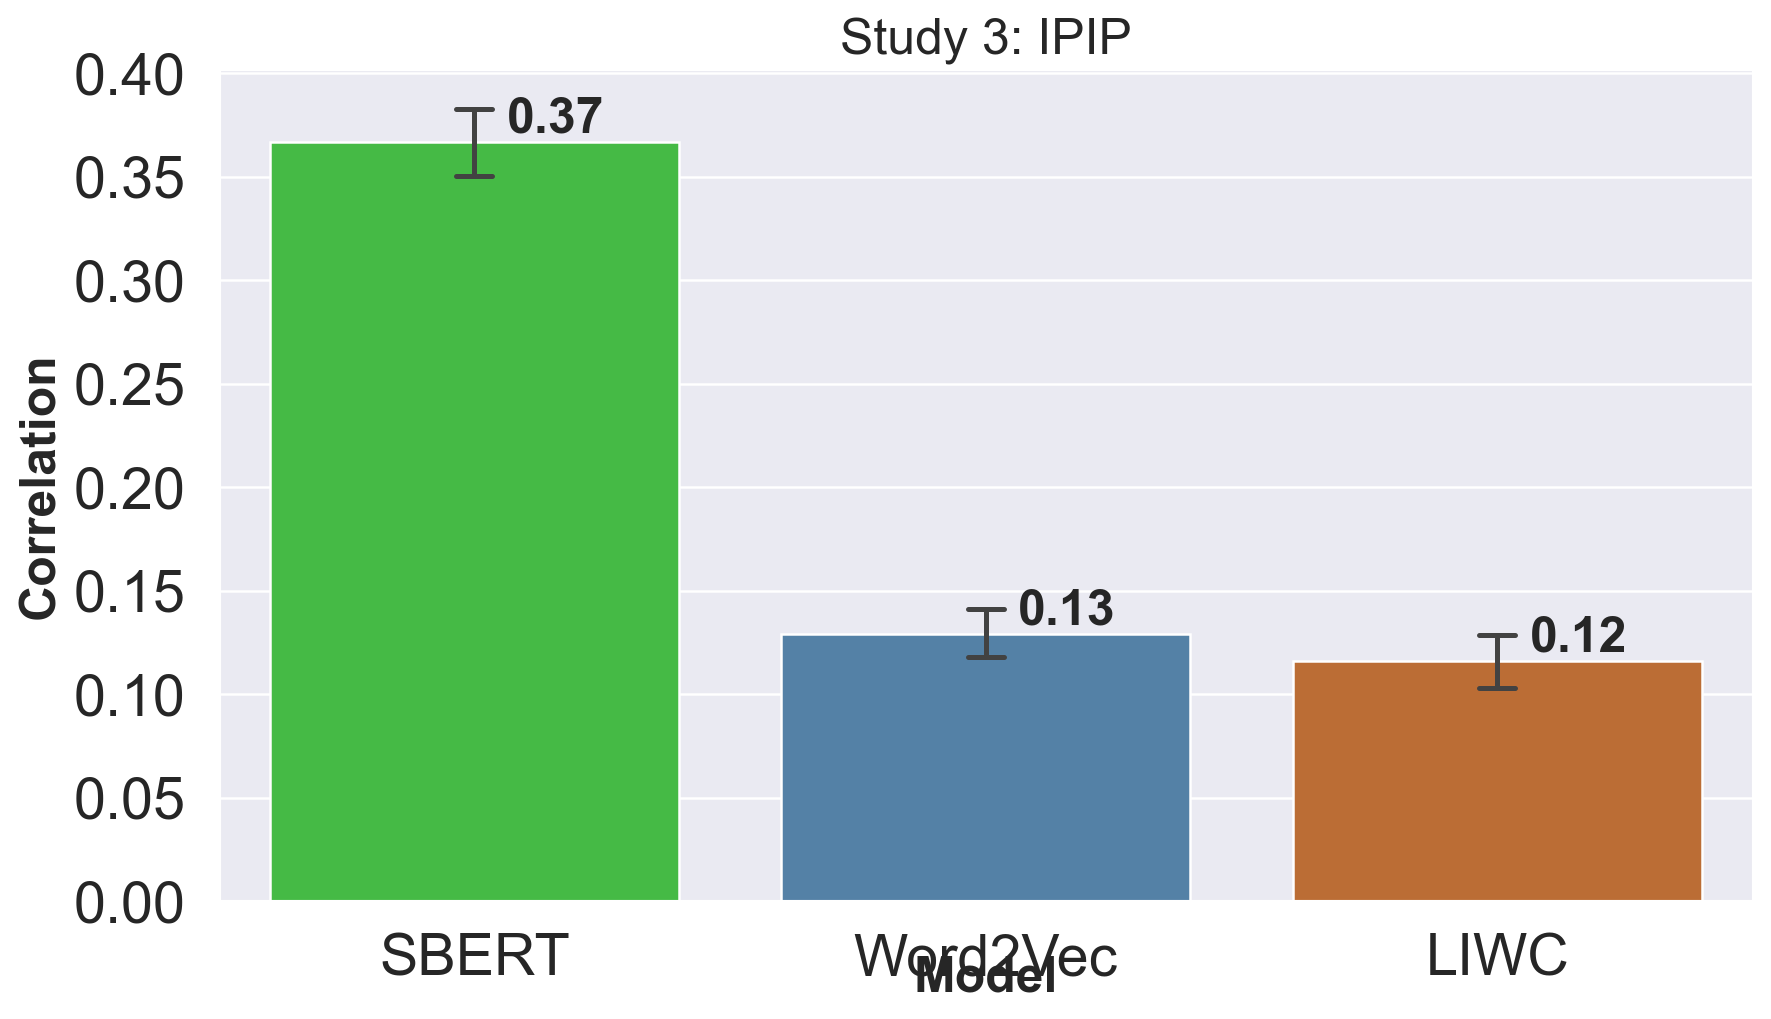

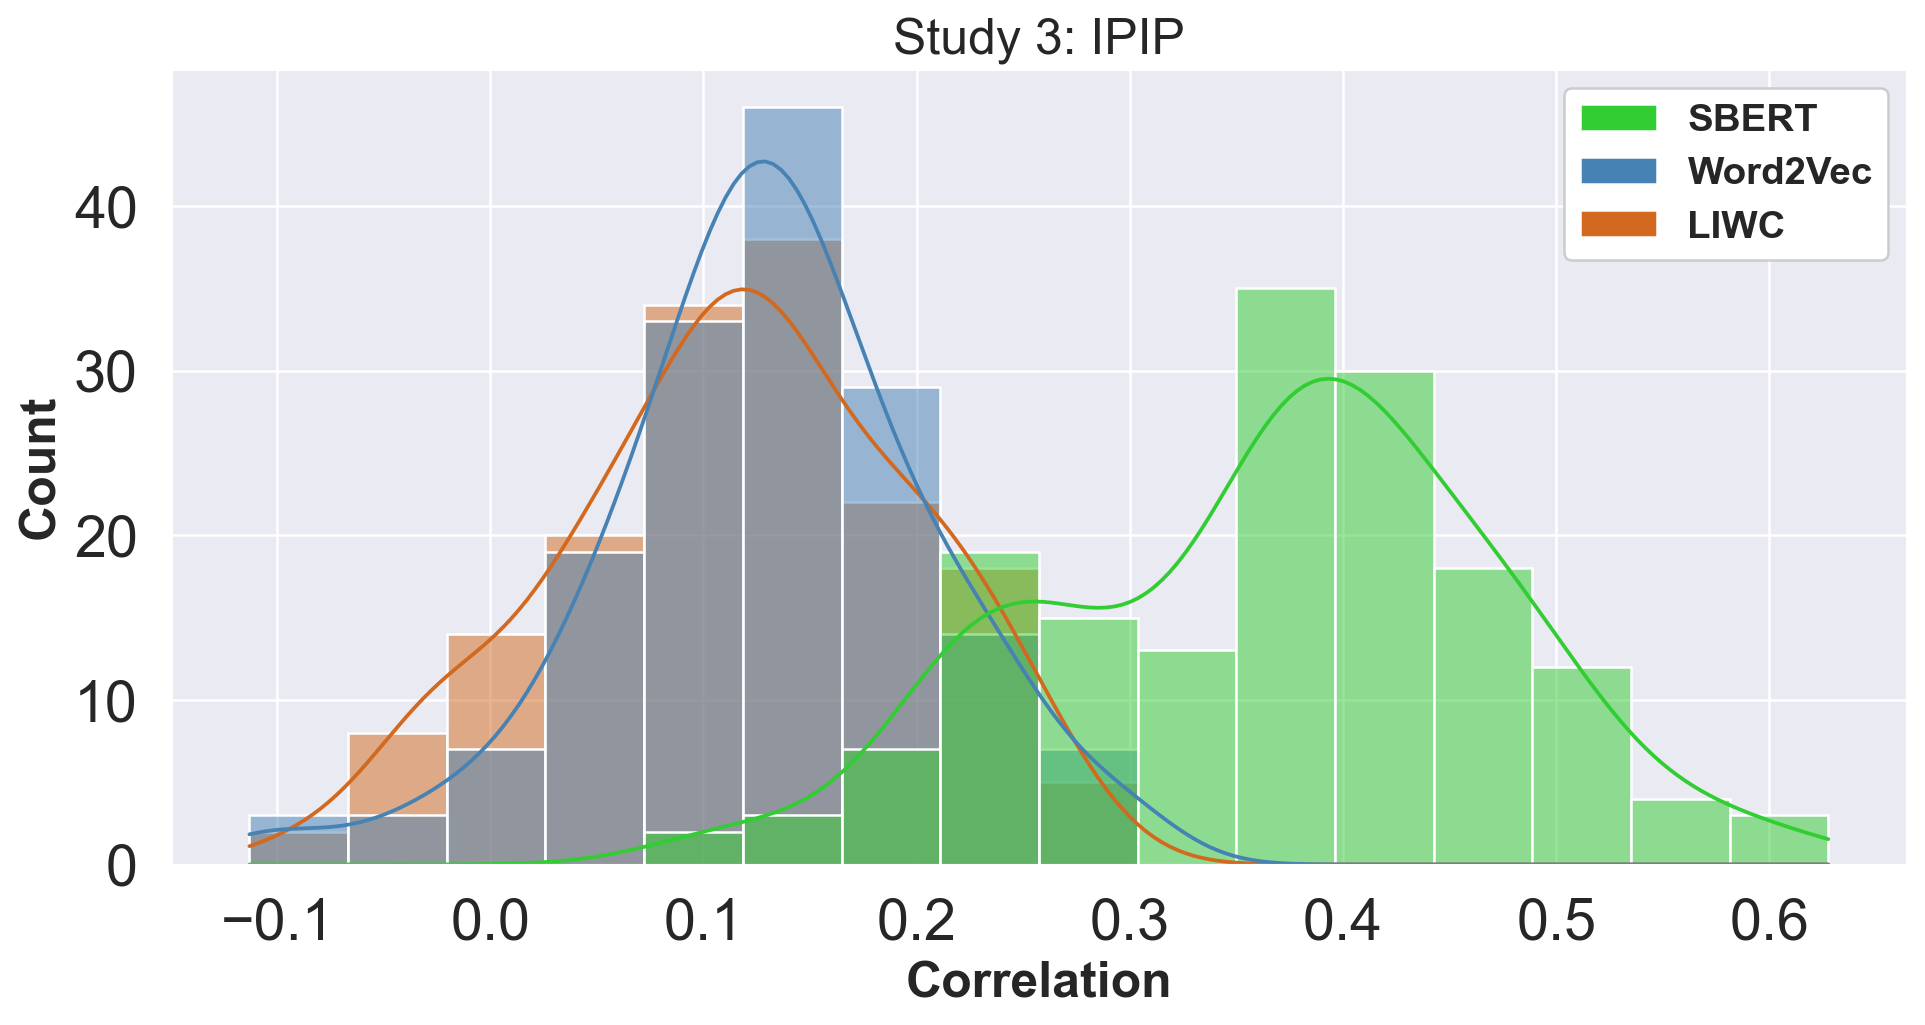

In [6]:
performance = pd.read_csv("../plot_data/performances_s3.csv", index_col=0)

# reshape data frame to show performance for each embedding type
cols = performance.columns.drop(['Dataset', 'Model'])
performance[cols] = performance[cols].astype(float)
performance = pd.melt(performance, id_vars=["Dataset", "Model"],var_name="predictor", value_name="metric value")
plot_data = performance[(performance['predictor'] == 'Correlation')].copy()
plot_data.loc[plot_data.Model == "Best Model", 'Model'] = "SBERT"

# rename for better display in plots
plot_data['Model'] = ["Word2Vec" if item=="WORD2VEC" else item for item in plot_data['Model']]
plot_data['Model'] = ["Average\nResponse" if item=="Average Response" else item for item in plot_data['Model']]

#create plots
fig  = plt.figure(figsize=(20, 36), dpi= 180)
sns.set(font_scale = 1)
order = ['IPIP']
dataset_names = ['Study 3: IPIP']

#Plot style and meta
plt.style.use('seaborn-v0_8')
sns.set_context('paper')
sns.set(font_scale = 1.4)
for i in range(4,5):

    #Add the performance plots:
    data = plot_data[(plot_data.Dataset == order[i-4]) & (plot_data.Model != "Average\nResponse")]
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    ax = sns.barplot(y='metric value', x='Model', orient='v', data=data, errorbar=('ci', 95), palette=["limegreen","steelblue", "chocolate", "sandybrown"], capsize=0.07, errwidth=2)
    for p in ax.patches:
      if p.get_height() < 0:
        height = -6
      else:
        height = 6
      ax.annotate("%.2f" % round(p.get_height(),2), xy=(p.get_x() + p.get_width() / 2, p.get_height()),
              xytext=(13, height + 3), textcoords='offset points', ha="left", va="center", fontweight='bold',fontsize=20)
    plt.ylabel("Correlation", fontweight='bold', fontsize=20)
    plt.xlabel("Model", fontweight='bold', fontsize=20, labelpad=-13)
    plt.title(dataset_names[i-4], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i) + ".pdf"
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

    #Add the distribution plots for each data set:
    fig  = plt.figure(figsize=(11, 6), dpi= 180)
    palette=["limegreen","steelblue", "chocolate"]
    ax = sns.histplot(data, x="metric value", kde=True, hue="Model", palette = palette)
    from matplotlib.patches import Patch
    handles = [Patch(facecolor=item) for item in palette]
    labels = data.Model.unique().tolist()
    ax.legend(handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})

    plt.ylabel("Count", fontweight='bold', fontsize=20)
    plt.xlabel("Correlation", fontweight='bold', fontsize=20)
    plt.title(dataset_names[i-4], fontsize=20)
    plt.xticks(fontsize=23)
    plt.yticks(fontsize=23)

    fig_name = "fig2_" + chr(65+2*i+1) + ".pdf"
    plt.savefig("../plot_data/" + fig_name, bbox_inches='tight')

plt.tight_layout()
plt.subplots_adjust(hspace = 1)
plt.show()